In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, auc)
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [12]:
X = pd.read_csv("../merge/merged_x.csv")
y = pd.read_csv("../merge/merged_y.csv").iloc[:,0]  

print(X.shape, y.shape)
X.head()

(89999, 56) (89999,)


,loan_type,loan_amount,loan_term,interest_rate,loan_purpose,loan_to_value_ratio,origination_channel,loan_officer_id,marketing_campaign,age,...,debt_service_ratio,payment_to_income_ratio,credit_utilization,credit_usage_amount,available_credit,total_monthly_debt_payment,annual_debt_payment,loan_to_annual_income,total_debt_amount,monthly_free_cash_flow
0,2,17700.0,36,12.50,0,0.000,2,1045,22,41,...,0.258402,0.115,0.841,142213.1,26886.9,1330.77,15969.24,0.286408,159913.1,3819.230000
1,1,114000.0,180,6.83,6,0.774,0,1011,1,38,...,0.589959,0.425,0.971,75932.2,2267.8,1406.07,16872.84,3.986014,189932.2,977.260000
2,2,9300.0,36,13.99,3,0.000,3,1084,10,18,...,0.302539,0.184,0.539,22314.6,19085.4,521.88,6262.56,0.449275,31614.6,1203.120000
3,2,8700.0,48,13.26,4,0.000,3,1048,0,27,...,0.199961,0.090,0.147,8820.0,51180.0,523.23,6278.76,0.277070,17520.0,2093.436667
4,2,7200.0,24,10.77,0,0.000,0,1055,18,26,...,0.284673,0.163,0.488,24253.6,25446.4,583.58,7002.96,0.292683,31453.6,1466.420000


In [19]:
def train_catboost_model(X_train, y_train, X_val=None, y_val=None, weight_ratio=20):
    """
    CatBoost modelini o'rgatish
    weight_ratio: Class 1 ning Class 0 ga nisbati (default: 20)
    """
    
    # Class weights hisoblash
    class_weights = {
        0: 1,
        1: weight_ratio
    }
    
    model = CatBoostClassifier(
        iterations=500,
        learning_rate=0.05,
        depth=8,
        l2_leaf_reg=3,
        loss_function='Logloss',
        class_weights=[class_weights[0], class_weights[1]],
        random_seed=42,
        verbose=False,  # Progress bar o'chirish
        early_stopping_rounds=50 if X_val is not None else None
    )
    
    if X_val is not None and y_val is not None:
        model.fit(
            X_train, y_train,
            eval_set=(X_val, y_val),
            verbose=False
        )
    else:
        model.fit(X_train, y_train)
    
    return model


In [20]:
def train_lightgbm_model(X_train, y_train, X_val=None, y_val=None, weight_ratio=20):
    """
    LightGBM modelini o'rgatish
    weight_ratio: Class 1 ning Class 0 ga nisbati (default: 20)
    """
    
    # Class weights hisoblash
    class_weights = {
        0: 1,
        1: weight_ratio
    }
    
    model = LGBMClassifier(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=8,
        num_leaves=31,
        min_child_samples=20,
        subsample=0.8,
        colsample_bytree=0.8,
        class_weight=class_weights,
        random_state=42,
        verbose=-1,  # Log messages o'chirish
        early_stopping_rounds=50 if X_val is not None else None
    )
    
    if X_val is not None and y_val is not None:
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            eval_metric='auc'
        )
    else:
        model.fit(X_train, y_train)
    
    return model



In [21]:
def find_optimal_threshold(model, X_val, y_val, cost_fn=10000, cost_fp=500):
    """
    Optimal threshold topish (biznes xarajatlarini hisobga olgan holda)
    cost_fn: False Negative xarajati (yomon mijozga kredit berish)
    cost_fp: False Positive xarajati (yaxshi mijozga rad etish)
    """
    
    y_proba = model.predict_proba(X_val)[:, 1]
    
    thresholds = np.arange(0.1, 0.9, 0.01)
    costs = []
    f1_scores = []
    
    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        
        tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
        
        total_cost = (fn * cost_fn) + (fp * cost_fp)
        costs.append(total_cost)
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        f1_scores.append(f1)
    
    optimal_idx = np.argmin(costs)
    optimal_threshold = thresholds[optimal_idx]
    
    f1_optimal_idx = np.argmax(f1_scores)
    f1_optimal_threshold = thresholds[f1_optimal_idx]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    ax1.plot(thresholds, costs, 'b-', linewidth=2)
    ax1.axvline(optimal_threshold, color='r', linestyle='--', 
                label=f'Optimal: {optimal_threshold:.3f}')
    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('Total Cost ($)')
    ax1.set_title('Business Cost vs Threshold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(thresholds, f1_scores, 'g-', linewidth=2)
    ax2.axvline(f1_optimal_threshold, color='r', linestyle='--', 
                label=f'Optimal: {f1_optimal_threshold:.3f}')
    ax2.set_xlabel('Threshold')
    ax2.set_ylabel('F1-Score')
    ax2.set_title('F1-Score vs Threshold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return optimal_threshold, f1_optimal_threshold


In [22]:
def evaluate_model(model, X_test, y_test, threshold=0.5, model_name="Model"):
    """
    Modelni batafsil baholash (barcha AUC metrikalar bilan)
    """
    from sklearn.metrics import average_precision_score
    
    # Bashoratlar
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)
    
    # Metrikalar
    print("="*60)
    print(f"{model_name} - THRESHOLD: {threshold:.3f}")
    print("="*60)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, 
                                target_names=['Class 0 (OK)', 'Class 1 (Reject)']))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    print("\nConfusion Matrix:")
    print(f"True Negatives (TN):  {tn:6d} - To'g'ri rad etildi")
    print(f"False Positives (FP): {fp:6d} - Yaxshi mijoz rad etildi (Yo'qotilgan foyda)")
    print(f"False Negatives (FN): {fn:6d} - Yomon mijozga kredit berildi (KATTA ZARAR!) 🚨")
    print(f"True Positives (TP):  {tp:6d} - To'g'ri aniqlandi")
    
    # Biznes ta'siri
    cost_fn = 10000  
    cost_fp = 500    
    total_cost = (fn * cost_fn) + (fp * cost_fp)
    
    print("\n" + "="*60)
    print("BIZNES TA'SIRI:")
    print("="*60)
    print(f"False Negative xarajati: ${fn * cost_fn:,} ({fn} ta × ${cost_fn:,})")
    print(f"False Positive xarajati: ${fp * cost_fp:,} ({fp} ta × ${cost_fp:,})")
    print(f"UMUMIY XARAJAT:         ${total_cost:,}")
    print("="*60)
    
    # AUC Metrikalar
    roc_auc = roc_auc_score(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)
    
    print("\n" + "="*60)
    print("AUC METRIKALARI:")
    print("="*60)
    print(f"ROC-AUC Score:  {roc_auc:.4f} (0.5=random, 1.0=perfect)")
    print(f"PR-AUC Score:   {pr_auc:.4f} (imbalanced data uchun muhim)")
    print("="*60)
    
    # Confusion Matrix visualization
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f'{model_name} - Confusion Matrix (Threshold = {threshold:.3f})')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    return {
        'accuracy': (tn + tp) / (tn + fp + fn + tp),
        'precision': tp / (tp + fp) if (tp + fp) > 0 else 0,
        'recall': tp / (tp + fn) if (tp + fn) > 0 else 0,
        'f1': 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'total_cost': total_cost,
        'fn_count': fn,
        'fp_count': fp
    }

In [23]:
def compare_models(metrics_dict):
    """
    Barcha modellarni taqqoslash (AUC metrikalari bilan)
    """
    print("\n" + "="*90)
    print("MODELLARNI TAQQOSLASH")
    print("="*90)
    
    comparison_data = {
        'Model': list(metrics_dict.keys()),
        'Precision': [f"{m['precision']:.3f}" for m in metrics_dict.values()],
        'Recall': [f"{m['recall']:.3f}" for m in metrics_dict.values()],
        'F1-Score': [f"{m['f1']:.3f}" for m in metrics_dict.values()],
        'ROC-AUC': [f"{m['roc_auc']:.3f}" for m in metrics_dict.values()],
        'PR-AUC': [f"{m['pr_auc']:.3f}" for m in metrics_dict.values()],
        'False Negatives': [m['fn_count'] for m in metrics_dict.values()],
        'Total Cost': [f"${m['total_cost']:,}" for m in metrics_dict.values()]
    }
    
    df_comparison = pd.DataFrame(comparison_data)
    print(df_comparison.to_string(index=False))
    print("="*90)
    
    # Eng yaxshi modelni aniqlash
    best_model = min(metrics_dict.items(), key=lambda x: x[1]['total_cost'])
    best_roc_auc = max(metrics_dict.items(), key=lambda x: x[1]['roc_auc'])
    best_pr_auc = max(metrics_dict.items(), key=lambda x: x[1]['pr_auc'])
    
    print(f"\n🏆 ENG YAXSHI MODEL (Cost bo'yicha): {best_model[0]}")
    print(f"   Total Cost: ${best_model[1]['total_cost']:,}")
    print(f"   False Negatives: {best_model[1]['fn_count']}")
    
    print(f"\n🎯 ENG YAXSHI ROC-AUC: {best_roc_auc[0]} ({best_roc_auc[1]['roc_auc']:.4f})")
    print(f"🎯 ENG YAXSHI PR-AUC: {best_pr_auc[0]} ({best_pr_auc[1]['pr_auc']:.4f})")


In [24]:
print("Ma'lumotlarni train/validation/test ga bo'lish...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

print(f"Train: {X_train_split.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print(f"Train Class 1: {y_train_split.sum()}, Val Class 1: {y_val.sum()}, Test Class 1: {y_test.sum()}")


Ma'lumotlarni train/validation/test ga bo'lish...
Train: (57599, 56), Val: (14400, 56), Test: (18000, 56)
Train Class 1: 2940, Val Class 1: 735, Test Class 1: 919


In [25]:
print("\n" + "="*80)
print("1. CATBOOST MODELINI O'RGATISH")
print("="*80)

catboost_model = train_catboost_model(
    X_train_split, y_train_split, 
    X_val, y_val, 
    weight_ratio=20
)
print("✓ CatBoost model tayyor!")


1. CATBOOST MODELINI O'RGATISH
✓ CatBoost model tayyor!


CatBoost uchun optimal threshold topilmoqda...


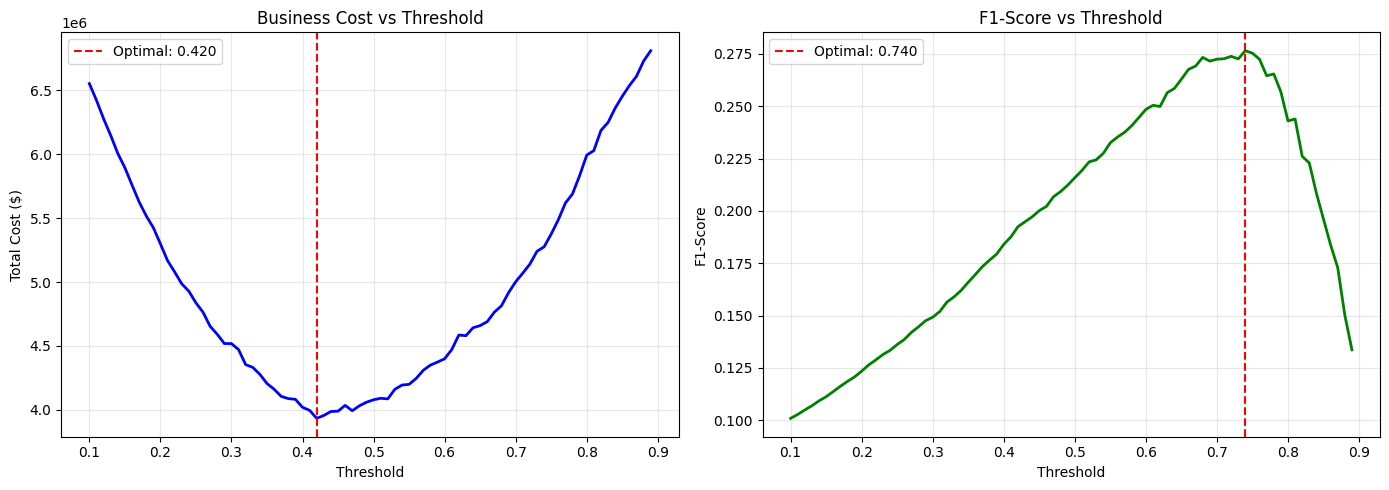

✓ Optimal threshold: 0.420
✓ F1-optimal threshold: 0.740


In [26]:
print("CatBoost uchun optimal threshold topilmoqda...")
cb_optimal_threshold, cb_f1_threshold = find_optimal_threshold(
    catboost_model, X_val, y_val, cost_fn=10000, cost_fp=500
)
print(f"✓ Optimal threshold: {cb_optimal_threshold:.3f}")
print(f"✓ F1-optimal threshold: {cb_f1_threshold:.3f}")


### CatBoost - Optimal Threshold ###
CatBoost - THRESHOLD: 0.420

Classification Report:
                  precision    recall  f1-score   support

    Class 0 (OK)       0.98      0.66      0.79     17081
Class 1 (Reject)       0.11      0.78      0.19       919

        accuracy                           0.66     18000
       macro avg       0.55      0.72      0.49     18000
    weighted avg       0.94      0.66      0.76     18000


Confusion Matrix:
True Negatives (TN):   11248 - To'g'ri rad etildi
False Positives (FP):   5833 - Yaxshi mijoz rad etildi (Yo'qotilgan foyda)
False Negatives (FN):    203 - Yomon mijozga kredit berildi (KATTA ZARAR!) 🚨
True Positives (TP):     716 - To'g'ri aniqlandi

BIZNES TA'SIRI:
False Negative xarajati: $2,030,000 (203 ta × $10,000)
False Positive xarajati: $2,916,500 (5833 ta × $500)
UMUMIY XARAJAT:         $4,946,500

AUC METRIKALARI:
ROC-AUC Score:  0.7931 (0.5=random, 1.0=perfect)
PR-AUC Score:   0.2216 (imbalanced data uchun muhim)


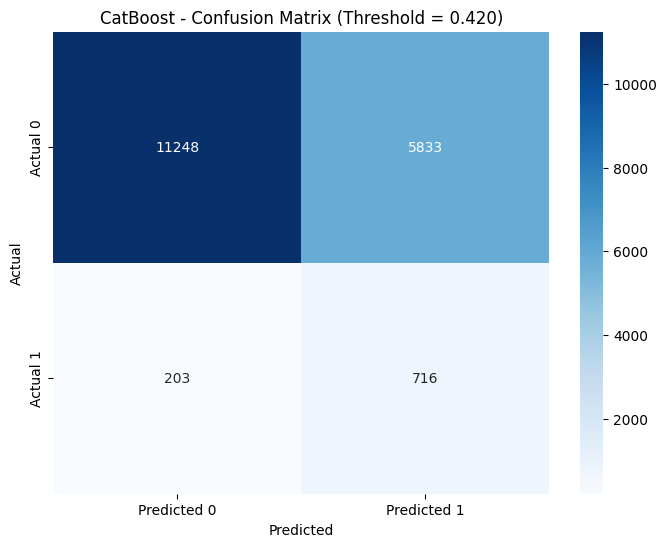

In [27]:
print("\n### CatBoost - Optimal Threshold ###")
catboost_metrics = evaluate_model(
    catboost_model, X_test, y_test, 
    threshold=cb_optimal_threshold,
    model_name="CatBoost"
)

In [28]:
print("\n" + "="*80)
print("2. LIGHTGBM MODELINI O'RGATISH")
print("="*80)

lgbm_model = train_lightgbm_model(
    X_train_split, y_train_split, 
    X_val, y_val, 
    weight_ratio=20
)
print("✓ LightGBM model tayyor!")


2. LIGHTGBM MODELINI O'RGATISH
✓ LightGBM model tayyor!


LightGBM uchun optimal threshold topilmoqda...


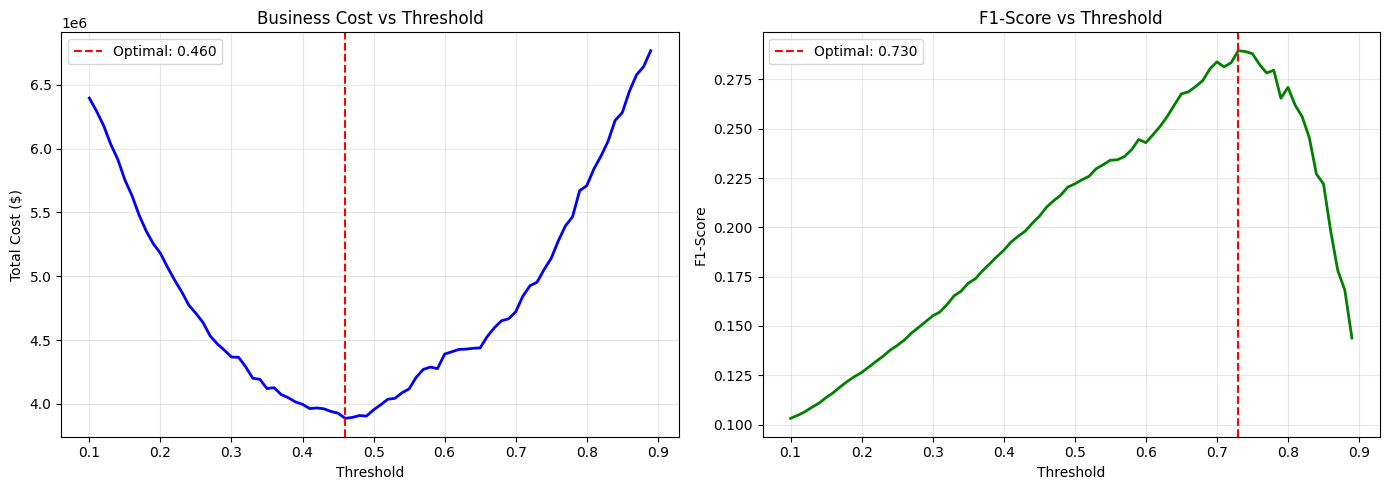

✓ Optimal threshold: 0.460
✓ F1-optimal threshold: 0.730


In [29]:
print("LightGBM uchun optimal threshold topilmoqda...")
lgbm_optimal_threshold, lgbm_f1_threshold = find_optimal_threshold(
    lgbm_model, X_val, y_val, cost_fn=10000, cost_fp=500
)
print(f"✓ Optimal threshold: {lgbm_optimal_threshold:.3f}")
print(f"✓ F1-optimal threshold: {lgbm_f1_threshold:.3f}")


### LightGBM - Optimal Threshold ###
LightGBM - THRESHOLD: 0.460

Classification Report:
                  precision    recall  f1-score   support

    Class 0 (OK)       0.98      0.72      0.83     17081
Class 1 (Reject)       0.12      0.73      0.21       919

        accuracy                           0.72     18000
       macro avg       0.55      0.73      0.52     18000
    weighted avg       0.94      0.72      0.80     18000


Confusion Matrix:
True Negatives (TN):   12316 - To'g'ri rad etildi
False Positives (FP):   4765 - Yaxshi mijoz rad etildi (Yo'qotilgan foyda)
False Negatives (FN):    248 - Yomon mijozga kredit berildi (KATTA ZARAR!) 🚨
True Positives (TP):     671 - To'g'ri aniqlandi

BIZNES TA'SIRI:
False Negative xarajati: $2,480,000 (248 ta × $10,000)
False Positive xarajati: $2,382,500 (4765 ta × $500)
UMUMIY XARAJAT:         $4,862,500

AUC METRIKALARI:
ROC-AUC Score:  0.7963 (0.5=random, 1.0=perfect)
PR-AUC Score:   0.2267 (imbalanced data uchun muhim)


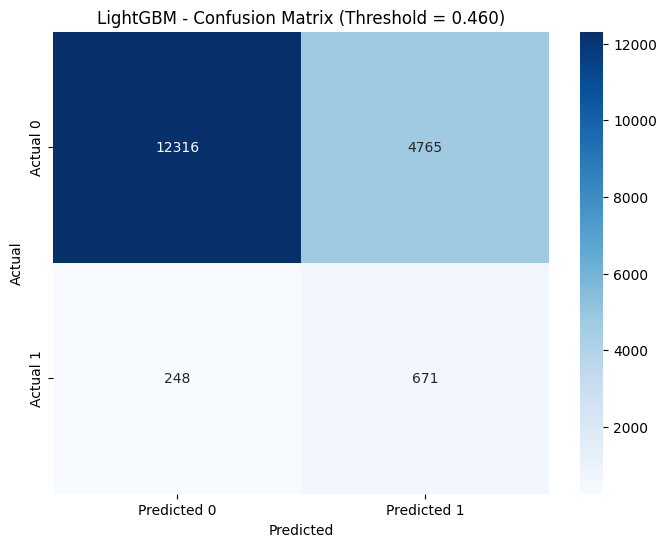

In [30]:
print("\n### LightGBM - Optimal Threshold ###")
lgbm_metrics = evaluate_model(
    lgbm_model, X_test, y_test, 
    threshold=lgbm_optimal_threshold,
    model_name="LightGBM"
)

In [31]:
metrics_all = {
    'CatBoost': catboost_metrics,
    'LightGBM': lgbm_metrics
}
compare_models(metrics_all)



MODELLARNI TAQQOSLASH
   Model Precision Recall F1-Score ROC-AUC PR-AUC  False Negatives Total Cost
CatBoost     0.109  0.779    0.192   0.793  0.222              203 $4,946,500
LightGBM     0.123  0.730    0.211   0.796  0.227              248 $4,862,500

🏆 ENG YAXSHI MODEL (Cost bo'yicha): LightGBM
   Total Cost: $4,862,500
   False Negatives: 248

🎯 ENG YAXSHI ROC-AUC: LightGBM (0.7963)
🎯 ENG YAXSHI PR-AUC: LightGBM (0.2267)


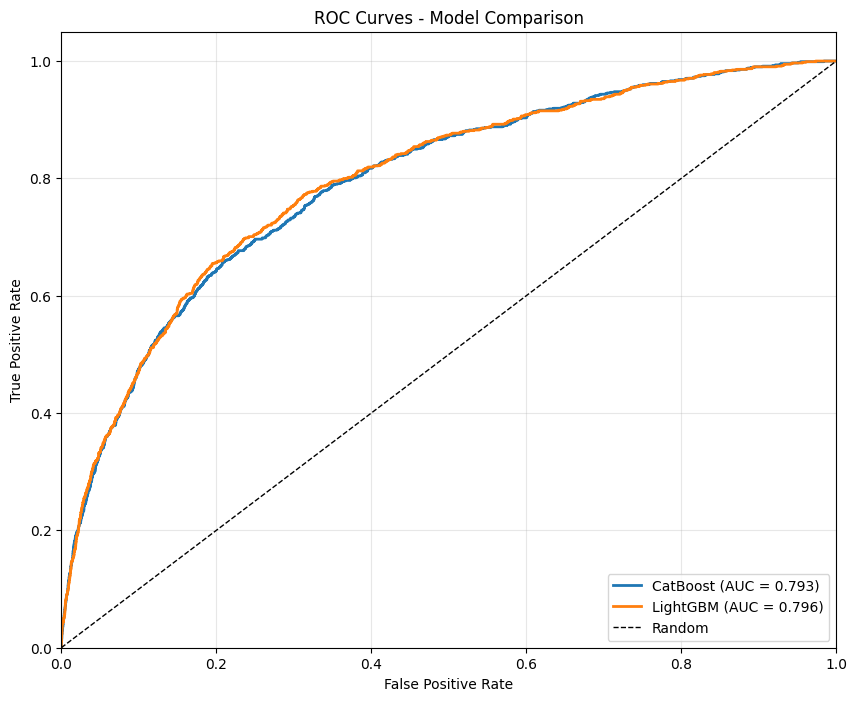

In [32]:
plt.figure(figsize=(10, 8))

for model_name, model in [('CatBoost', catboost_model), 
                           ('LightGBM', lgbm_model)]:
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, linewidth=2, 
            label=f'{model_name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Model Comparison')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()